In [ ]:
import pandas as pd 
import numpy as np

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('dataset',seed=123,shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE )

Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
(32,)
[0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 2 0 0 0 0 1 1 0]


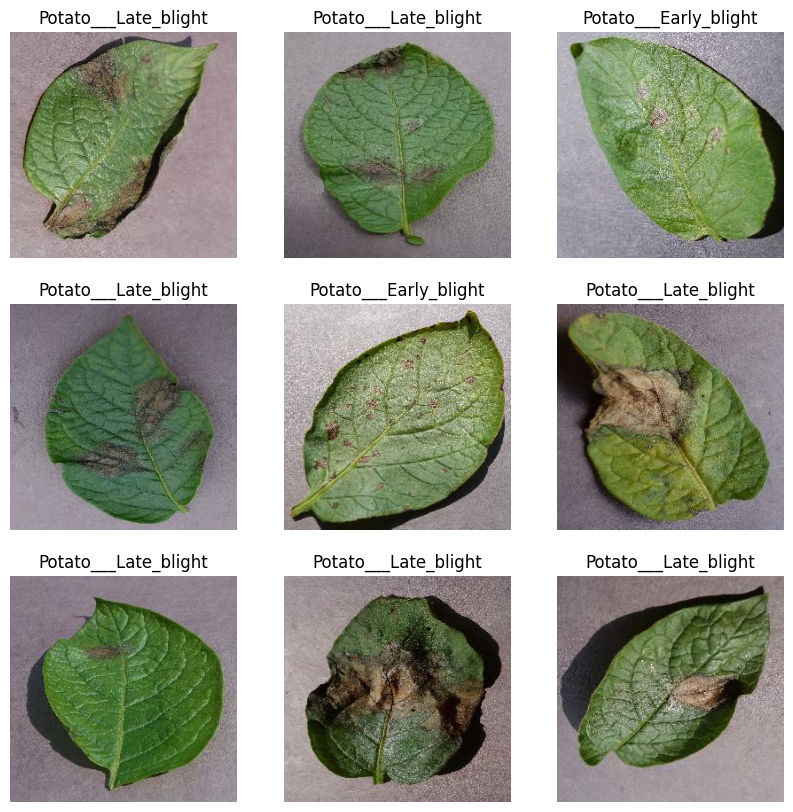

In [12]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
len(dataset)

68

In [14]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [15]:

train_ds = dataset.take(54)
len(train_ds)

54

In [16]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [17]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [18]:

val_ds = test_ds.take(6)
len(val_ds)

6

In [19]:

test_ds = test_ds.skip(6)
len(test_ds)

8

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [22]:
len(train_ds)


54

In [23]:
len(val_ds)


6

In [24]:

len(test_ds)

8

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

In [30]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),
    ]
)

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

NameError: name 'BATCH_SIZE' is not defined

In [32]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [34]:

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 919ms/step - accuracy: 0.4819 - loss: 0.9642 - val_accuracy: 0.5260 - val_loss: 0.8579
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 45s 826ms/step - accuracy: 0.6232 - loss: 0.7896 - val_accuracy: 0.7344 - val_loss: 1.2879
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 808ms/step - accuracy: 0.7550 - loss: 0.5717 - val_accuracy: 0.7812 - val_loss: 0.5905
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 819ms/step - accuracy: 0.8553 - loss: 0.3722 - val_accuracy: 0.8906 - val_loss: 0.3220
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 839ms/step - accuracy: 0.9071 - loss: 0.2545 - val_accuracy: 0.8490 - val_loss: 0.3854
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 875ms/step - accuracy: 0.9140 - loss: 0.2208 - val_accuracy: 0.9115 - val_loss: 0.2644
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 872ms/step - accuracy: 0.9255 - loss: 0.2057 - val_accuracy: 0.9479 - val_loss: 0.1880
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 805ms/step - accuracy: 0.9200 - loss: 0.1957 - val_accu

In [38]:
import os
# Only include numeric directory names
model_dirs = [i for i in os.listdir("models") if i.isdigit()]
model_version = max([int(i) for i in model_dirs] + [0]) + 1
model.save(f"models/{model_version}.keras")

In [35]:
model.save("models/potatoes.h5")

In [ ]:
# import numpy as np
# for images_batch, labels_batch in test_ds.take(1):
    
#     first_image = images_batch[0].numpy().astype('uint8')
#     first_label = labels_batch[0].numpy()
    
#     print("first image to predict")
#     plt.imshow(first_image)
#     print("actual label:",class_names[first_label])
    
#     batch_prediction = model.predict(images_batch)
#     print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
# def predict(model, img):
#     img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
#     img_array = tf.expand_dims(img_array, 0)

#     predictions = model.predict(img_array)

#     predicted_class = class_names[np.argmax(predictions[0])]
#     confidence = round(100 * (np.max(predictions[0])), 2)
#     return predicted_class, confidence

In [ ]:

# plt.figure(figsize=(15, 15))
# for images, labels in test_ds.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
        
#         predicted_class, confidence = predict(model, images[i].numpy())
#         actual_class = class_names[labels[i]] 
        
#         plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
#         plt.axis("off")

In [40]:
scores = model.evaluate(test_ds)
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.9390 - loss: 0.2386


[0.2541136145591736, 0.9296875]

In [39]:
history


In [41]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [43]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [44]:

type(history.history['loss'])

list

In [45]:
history.history['loss'][:5] # show loss for first 5 epochs


[0.9214827418327332,
 0.7289295196533203,
 0.4827943742275238,
 0.35351046919822693,
 0.26311278343200684]

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

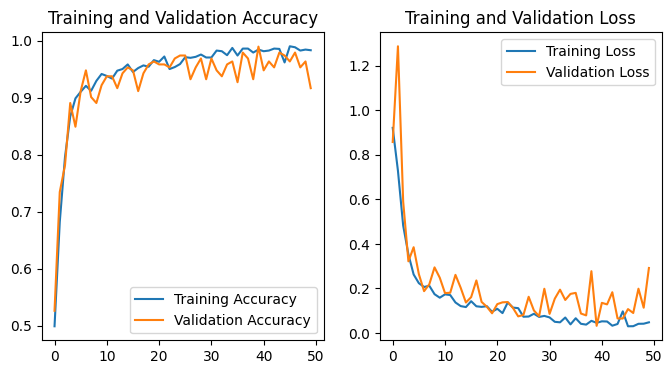

In [53]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
predicted label: Potato___Early_blight


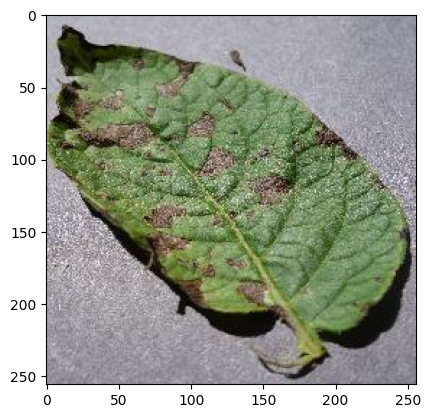

In [48]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [49]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


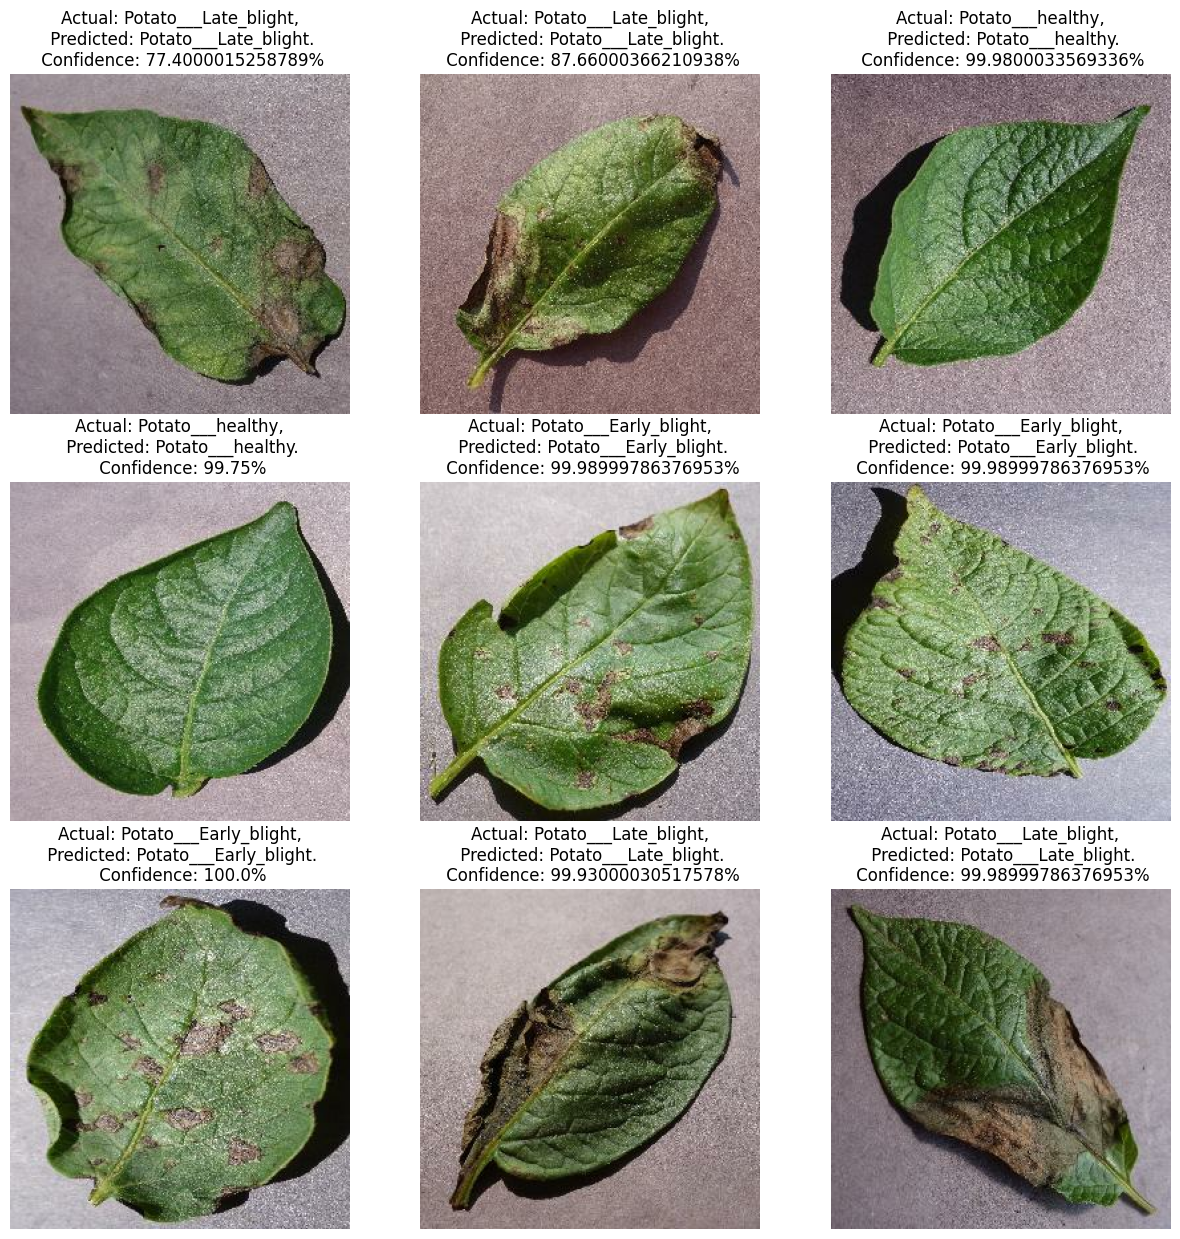

In [50]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")